# Capítulo 3 - Modelo de séries temporais de despesa INSS (2000-2023) 
## Análise de Séries Temporais dos Gastos Previdenciários do INSS no Século XXI

**Universidade Federal Rural do Rio de Janeiro (UFRRJ)**  
**Instituto Multidisciplinar – Curso de Ciências Econômicas**  

**Autor:** Victor Flávio P. Dornelos  
**Orientadores:** Profª Dra. Elena Soihet e Profº Dr. Julio Cezar Russo

# 1- Biblioteca

In [46]:
# Instalando bibliotecas necessárias
#pip install -r requirements.txt

In [47]:
# Importando as principais bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_arch
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# 2- Tratamento de dados

In [48]:
# Criando o DF
df= pd.read_csv('dados_entrada/despesa_inss_2023.csv', sep=';', encoding='latin1',header=1)

# Drop total
df.drop('Total',axis=1,inplace=True)

In [49]:
# Substituir vírgulas por pontos para converter strings para floats
df.iloc[:, 1:] = df.iloc[:, 1:].replace(',', '.', regex=True).astype(float)

# Transformar o DataFrame no formato longo (melt)
df_long = df.melt(id_vars=['Ano'], var_name='Mês', value_name='Valor')

# Mapeamento dos meses para formato numérico
month_mapping = {
    'Janeiro': '01',
    'Fevereiro': '02',
    'Março': '03',
    'Abril': '04',
    'Maio': '05',
    'Junho': '06',
    'Julho': '07',
    'Agosto': '08',
    'Setembro': '09',
    'Outubro': '10',
    'Novembro': '11',
    'Dezembro': '12'
}

# Mapear os meses e remover linhas inválidas
df_long['Mês'] = df_long['Mês'].map(month_mapping)
df_long = df_long[df_long['Mês'].notna()]

# Criar a coluna 'Data' no formato MM/YYYY
df_long['Data'] = pd.to_datetime(df_long['Ano'].astype(str) + '/' + df_long['Mês'], format='%Y/%m', errors='coerce')

# Remover linhas inválidas onde 'Data' é NaT
df_long = df_long[df_long['Data'].notna()]

# Selecionar as colunas finais
df_final = df_long[['Data', 'Valor']]

In [50]:
# Organizar o DataFrame pela coluna 'Data' em ordem crescente
df_final = df_final.sort_values(by='Data')

# Resetar os índices para manter o DataFrame limpo (opcional)
df_final = df_final.reset_index(drop=True)

In [51]:
df = df_final

# Data vira index
df.set_index('Data', inplace=True)
# Somente valor depois de data 1999-12-01
df = df[df.index >= '2000-01-01']

# Converter a coluna 'Valor' para float
df['Valor'] = df['Valor'].astype(float)

# Arredondar para milhao e duas casas decimais
df['Valor'] = df['Valor'] / 1000000
df['Valor'] = df['Valor'].round(2)

df3 = df.copy()
df5 = df.copy()
df6 = df.copy()
df_sarima = df.copy()
df_fb = df.copy()

In [52]:
df_sarima.to_excel('dados_saida/df_sarima.xlsx')

# 3 - Análise de dados da serie temporal

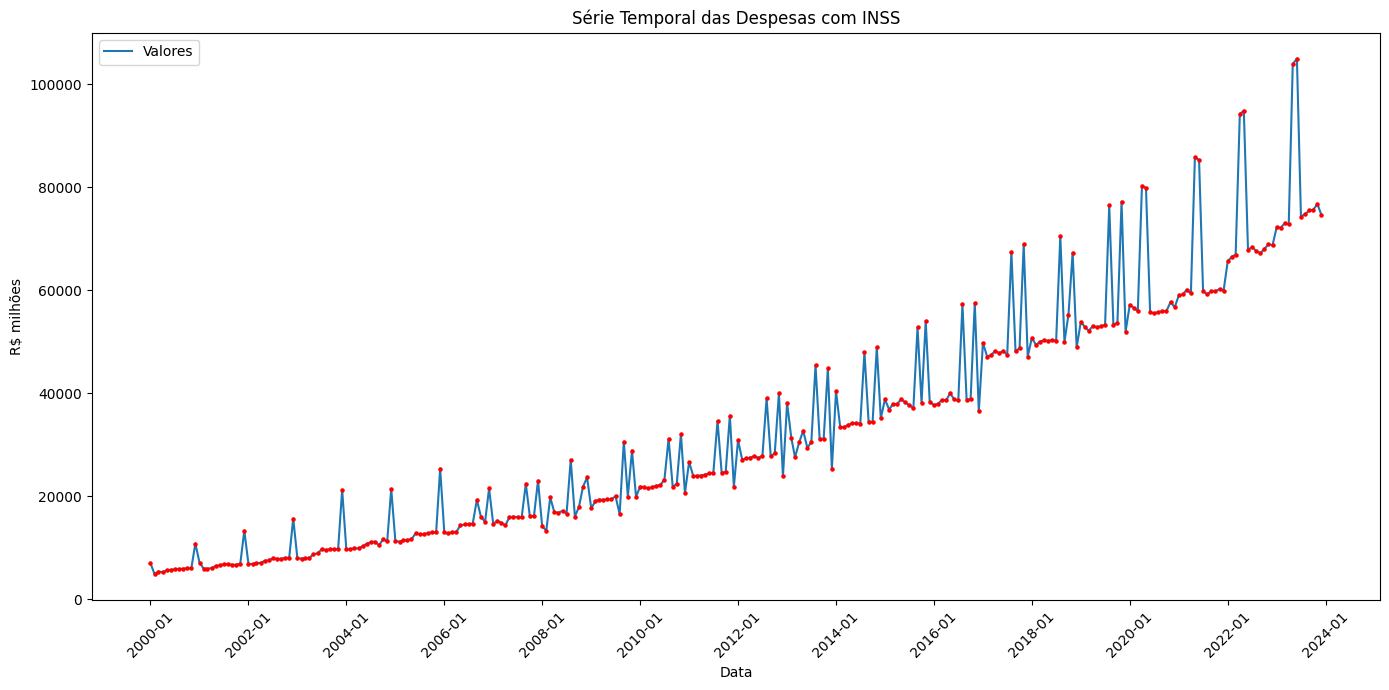

In [53]:
plt.figure(figsize=(14, 7))
sns.lineplot(x=df.index, y=df['Valor'], label='Valores')
plt.scatter(df.index, df['Valor'], color='red', s=5, zorder=5)

# Configurando o formato e os ticks do eixo X
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Intervalo de 2 anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45)

# Configurações adicionais
plt.title('Série Temporal das Despesas com INSS')
plt.xlabel('Data')
plt.ylabel('R$ milhões')
plt.tight_layout()
plt.grid(False)
plt.show()


In [54]:
# Criar o gráfico de série temporal interativo
fig = px.line(
    df_final,
    x=df_final.index,
    y='Valor',
    title='Série Temporal dos Gastos com INSS',
    labels={'x': 'Data', 'Valor': 'R$ milhões'},
)

# Ajustar layout para melhor visualização
fig.update_layout(
    xaxis_title='Data',
    yaxis_title='R$ milhões',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
    template='plotly_white'
)

# Exibir o gráfico interativo
fig.show()

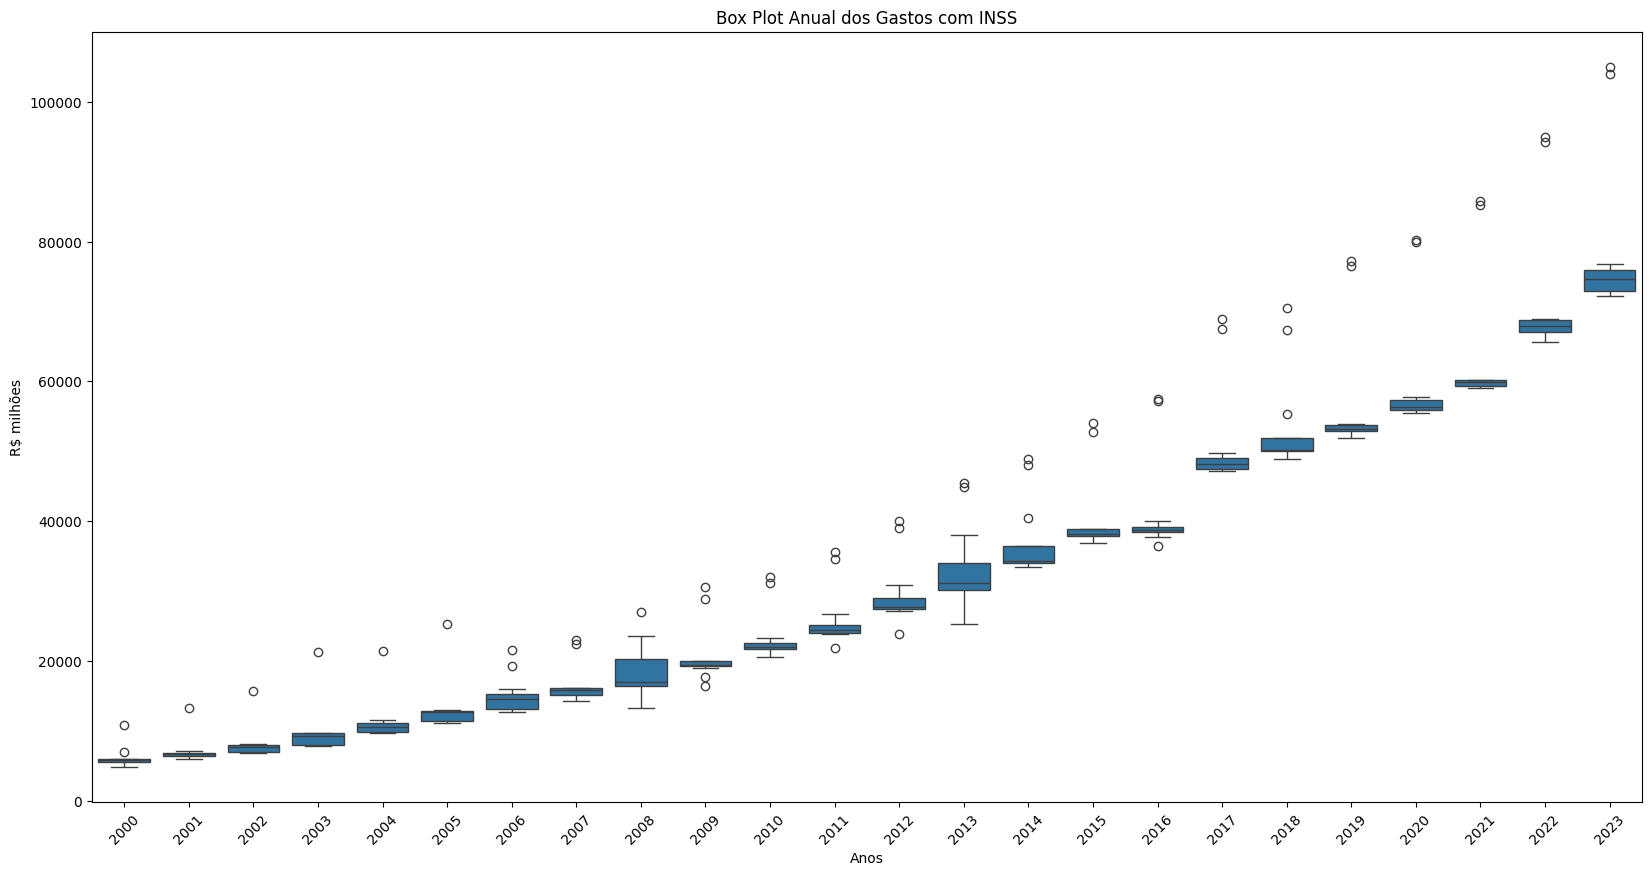

In [55]:
# Criando gráfico Box Plot anual
df['Ano'] = df.index.year


plt.figure(figsize=(20, 10))
sns.boxplot(x='Ano', y='Valor', data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Box Plot Anual dos Gastos com INSS')
plt.xlabel('Anos')
plt.ylabel('R$ milhões')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

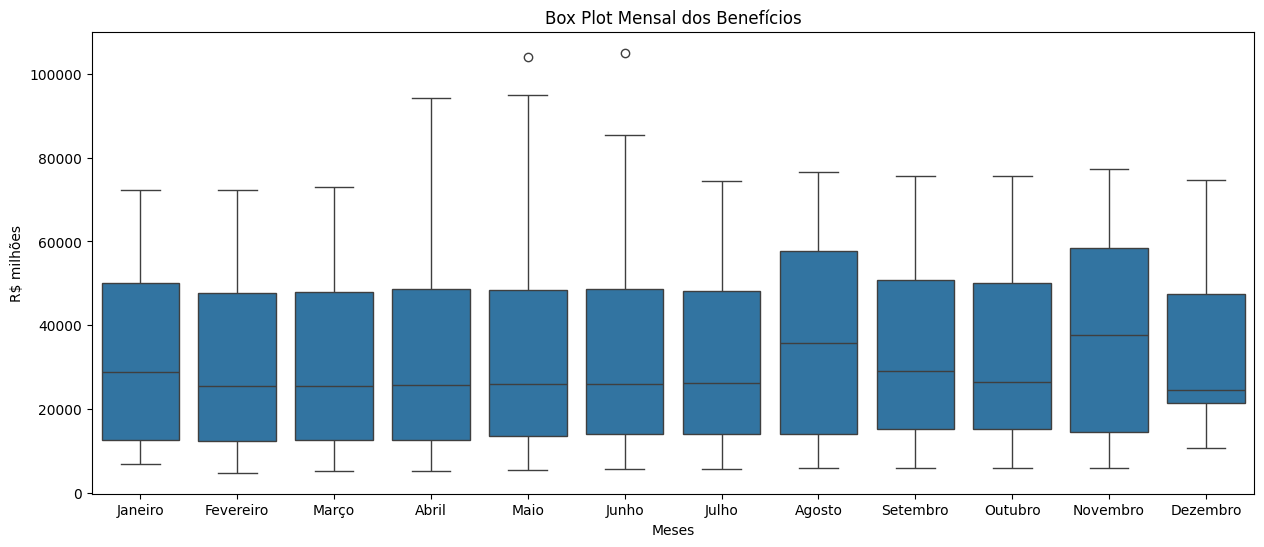

In [56]:
# Analisando efeito sazonal por meio do Box Plot
meses = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
         7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

df['Mês'] = df.index.month.map(meses)


plt.figure(figsize=(15, 6))
sns.boxplot(x='Mês', y='Valor', data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Box Plot Mensal dos Benefícios')
plt.xlabel('Meses')
plt.ylabel('R$ milhões')
plt.grid(False)
plt.show()

In [57]:
# Decompondo a série para novas análises
serie_temporal = df['Valor']
decomposicao = sm.tsa.seasonal_decompose(serie_temporal, model='additive')

<Figure size 2000x1000 with 0 Axes>

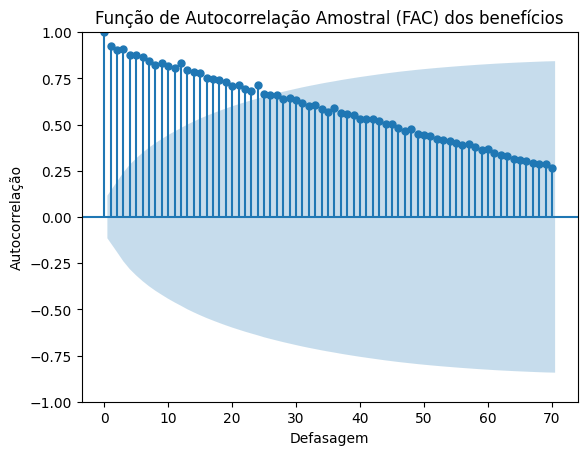

In [58]:
# Criando gráfico de FAC
plt.figure(figsize=(20, 10))
plot_acf(serie_temporal, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

<Figure size 2000x1000 with 0 Axes>

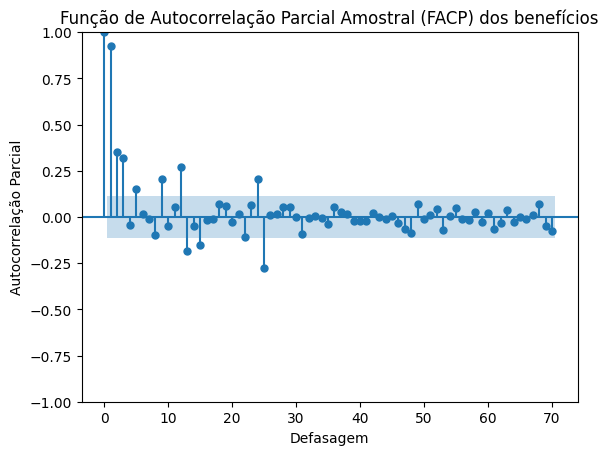

In [59]:
# Criando gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(serie_temporal, lags=70)  
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.show()

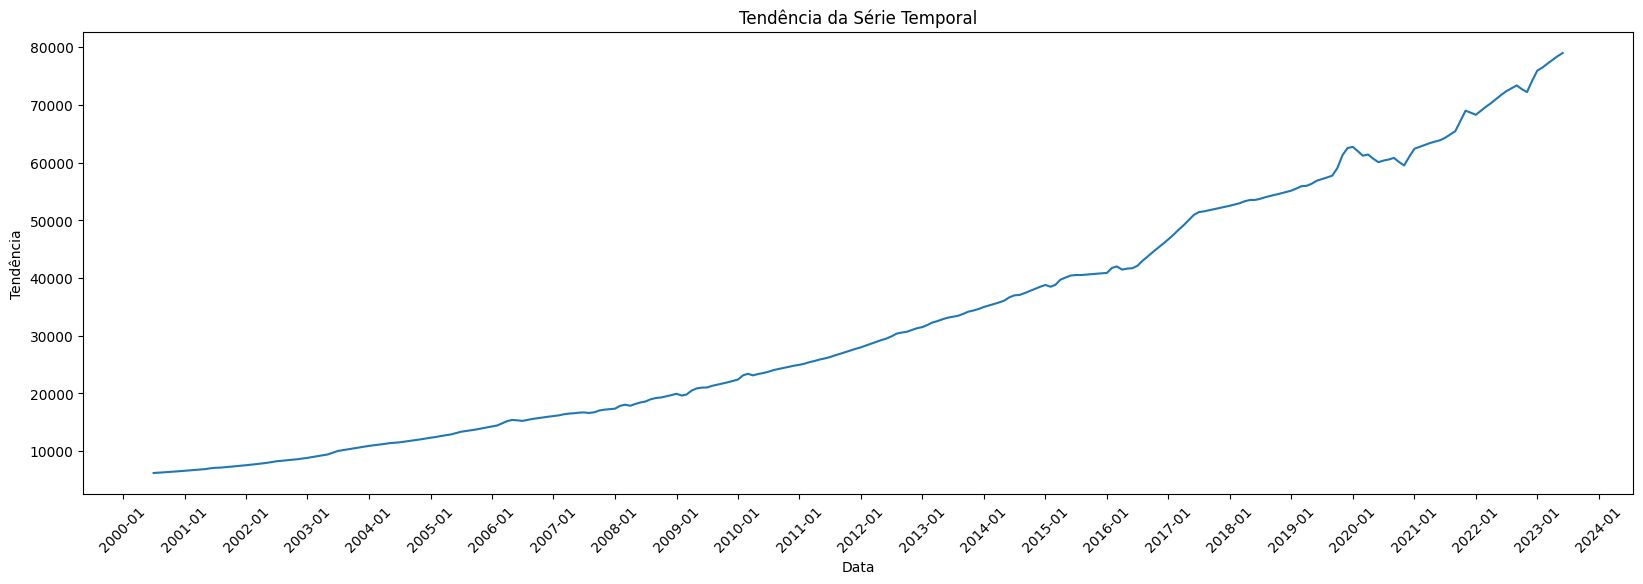

In [60]:
# Gráfico de tendência
plt.figure(figsize=(20, 6))
sns.lineplot(data=decomposicao.trend)
plt.title('Tendência da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.ylabel('Tendência')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

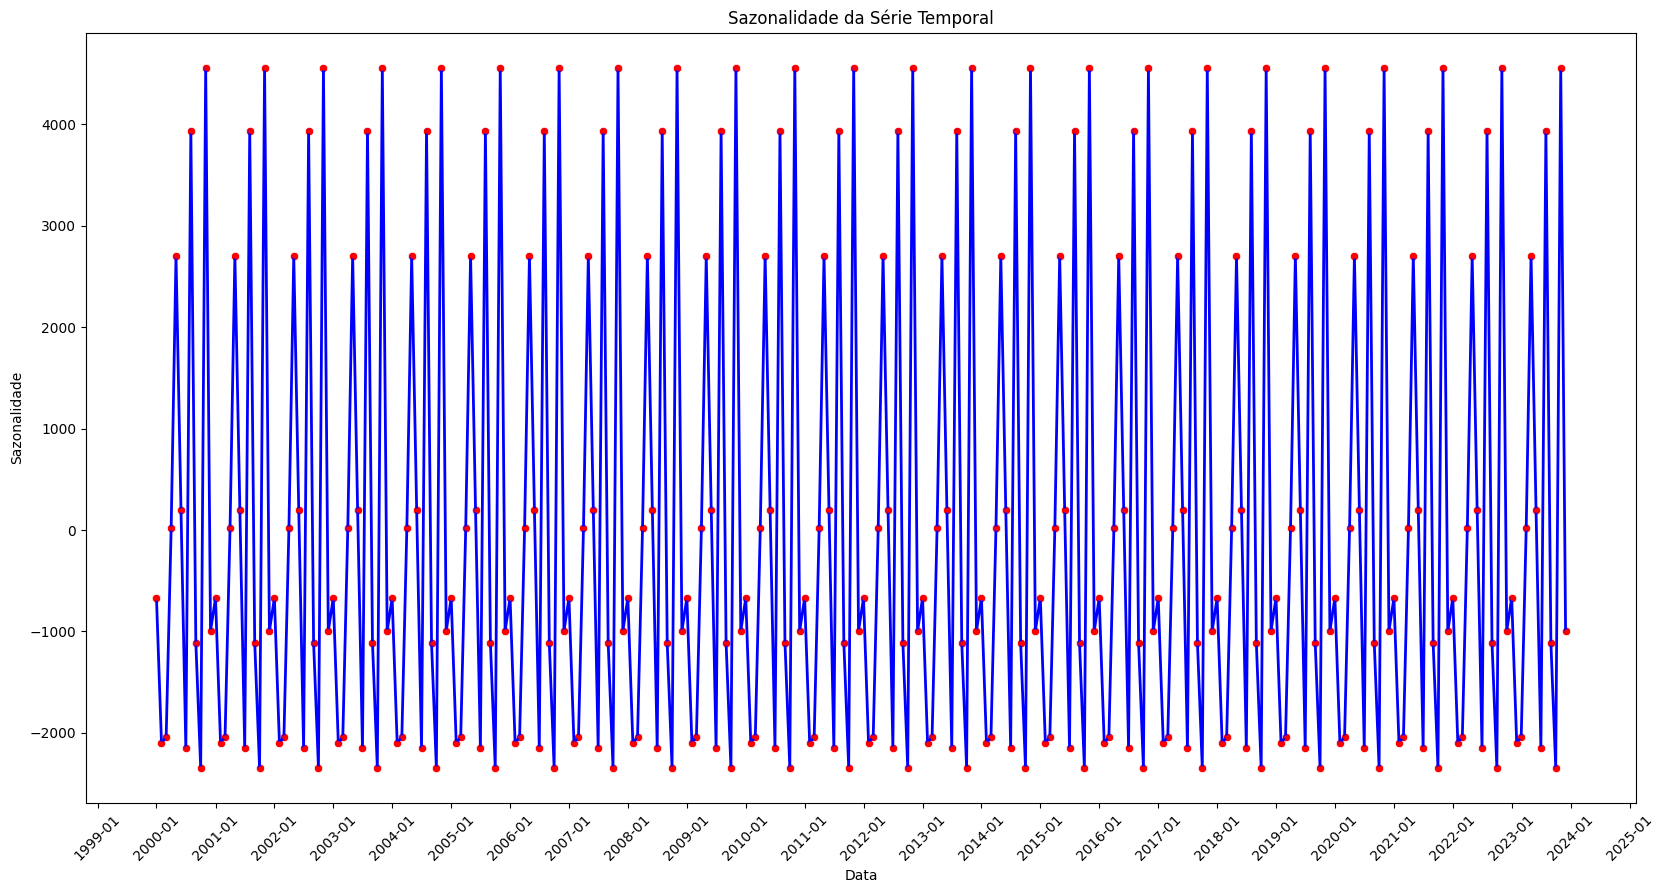

In [61]:
# Gráfico de Sazonalidade
plt.figure(figsize=(20, 10))
sns.lineplot(data=decomposicao.seasonal, color='blue', linewidth=2)
sns.scatterplot(data=decomposicao.seasonal, color='red', marker='o')
plt.scatter(decomposicao.seasonal.index, decomposicao.seasonal.values, color='red', s=5, zorder=5)
plt.title('Sazonalidade da Série Temporal')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Sazonalidade')
plt.xticks(rotation=45)
plt.show()

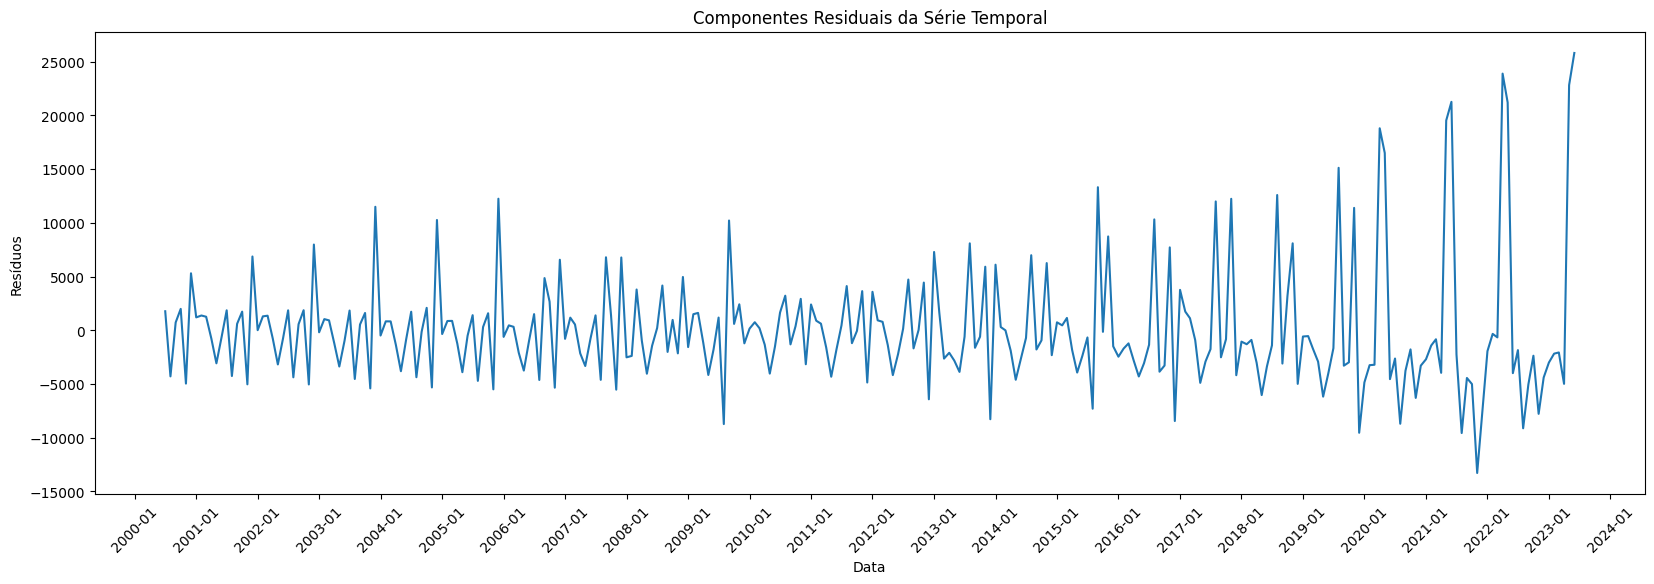

In [62]:
# Gráfico de ruído
plt.figure(figsize=(20,6))
sns.lineplot(data=decomposicao.resid)
plt.title('Componentes Residuais da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Resíduos')
plt.xticks(rotation=45)
plt.show()


In [63]:
# Realizando teste de hipótese de estacionalidade
result= adfuller(df3)
print(f'P-valor {result[1]}')

P-valor 1.0


In [64]:
# Realizando uma diferenciação na série para corrigir a estacionalidade
df3= df3.diff()
df3=df3.dropna()
result2= adfuller(df3)
print(f'P-valor {result2[1]}')

P-valor 1.589928192609075e-12


<Figure size 2000x600 with 0 Axes>

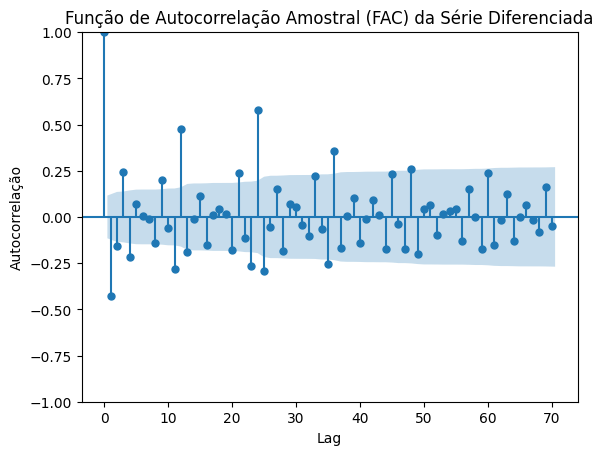

In [65]:
# Novo gráfico FAC
plt.figure(figsize=(20, 6))
plot_acf(df3, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) da Série Diferenciada')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

In [66]:
# Garantindo que a série está em formato correto
N = len(df3)  # Número de observações na série

# Cálculo da função de autocorrelação (FAC) até lag 11
fac_values = sm.tsa.acf(df3, nlags=11)

# Intervalo de confiança para significância estatística (95%)
z_score = 1.96  # Para 95% de confiança
threshold = z_score / np.sqrt(N)  # Margem de erro de 5%

# Criar uma lista apenas com os lags significativos
lags_significativos = [lag for lag, val in enumerate(fac_values) if abs(val) > threshold]

# Exibir a lista de lags significativos
print("Lags com dependência significativa:", lags_significativos)




Lags com dependência significativa: [0, 1, 2, 3, 4, 8, 9, 11]


In [67]:
# fac menor igual a 4
fac = lags_significativos 

<Figure size 2000x1000 with 0 Axes>

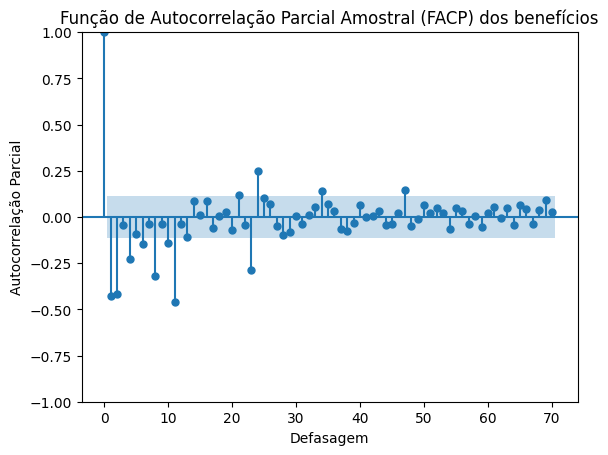

In [68]:
# Novo gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(df3, lags=70)  # Define o número de lags para calcular a FACP
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.grid(False)
plt.show()

In [69]:
# Garantindo que a série está em formato correto
N = len(df3)  # Número de observações na série

# Cálculo da função de autocorrelação parcial (FACP) até lag 11
facp_values = sm.tsa.pacf(df3, nlags=11)

# Intervalo de confiança para significância estatística (95%)
z_score = 1.96  # Para 95% de confiança
threshold = z_score / np.sqrt(N)  # Margem de erro de 5%

# Criar uma lista apenas com os lags significativos
lags_significativos_facp = [lag for lag, val in enumerate(facp_values) if abs(val) > threshold]

# Exibir a lista de lags significativos na FACP
print("Lags com dependência significativa na FACP:", lags_significativos_facp)

Lags com dependência significativa na FACP: [0, 1, 2, 4, 6, 8, 10, 11]


In [70]:
facp = lags_significativos_facp

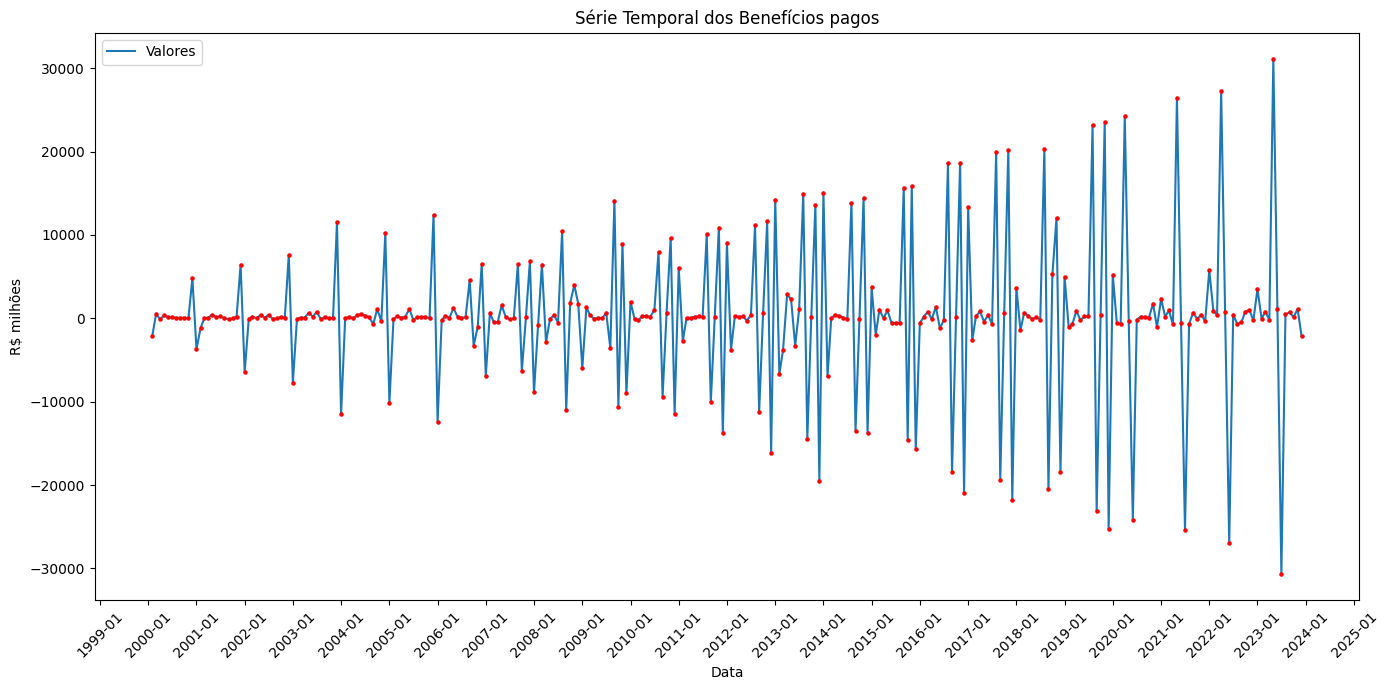

In [71]:
# Novo gráfico de série temporal
plt.figure(figsize=(14, 7))
sns.lineplot(x=df3.index, y=df3['Valor'], label='Valores')
plt.scatter(df3.index, df3['Valor'], color='red', s=5, zorder=5)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45)


plt.title('Série Temporal dos Benefícios pagos')
plt.xlabel('Data')
plt.ylabel('R$ milhões')

# Mostrar o gráfico
plt.tight_layout()
plt.grid(False)
plt.show()


In [72]:
s = 12  
N = len(df3)  # Número de observações na série

# Diferenciar sazonalmente a série (para remover efeitos sazonais)
df3_s_diff = df3.diff(s).dropna()

# Calcular FAC e FACP até 3 ciclos sazonais (36 lags)
fac_values = sm.tsa.acf(df3_s_diff, nlags=s*3)
facp_values = sm.tsa.pacf(df3_s_diff, nlags=s*3)

# Intervalo de confiança para significância estatística (95%)
z_score = 1.96  
threshold = z_score / np.sqrt(N)  

# Criar listas com os lags significativos
lags_significativos_fac = [lag for lag, val in enumerate(fac_values) if abs(val) > threshold]
lags_significativos_facp = [lag for lag, val in enumerate(facp_values) if abs(val) > threshold]

# Exibir os resultados
print("Lags significativos na FAC (Q):", lags_significativos_fac)
print("Lags significativos na FACP (P):", lags_significativos_facp)

Lags significativos na FAC (Q): [0, 1, 2, 3, 4, 5, 8, 11, 12, 13, 14, 15, 17, 20, 24, 25, 29, 31, 32]
Lags significativos na FACP (P): [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [73]:
# fac ate  5
fac_s = lags_significativos_fac 

# facp ate 4
facp_s = lags_significativos_facp 

# 4- MODELO SARIMA

In [74]:
# Importando bibliotecas para estimar os erros
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [75]:
# Criando uma função para um parâmetro de erro
def mean_percentage_error(Y,y):
    mpe = np.mean((Y - y )/ Y) * 100
    return mpe

In [76]:
# Função para criar DF com valores dos erros
def teste_erro(serie,previsao):

    MAD = mean_absolute_error(y_true=serie,y_pred=previsao)
    MAPE = mean_absolute_percentage_error(y_true=serie,y_pred=previsao)
    MSD = mean_squared_error(y_true=serie,y_pred=previsao)
    MPE = mean_percentage_error(serie,previsao)

    erros = pd.DataFrame({
        'Metric': ['MAD', 'MAPE', 'MSD', 'MPE'],
        'Value': [MAD, MAPE, MSD, MPE]
    })
    
    return erros

In [77]:
# print fac e facp 
print(fac)
print(facp)
print(fac_s)
print(facp_s)

[0, 1, 2, 3, 4, 8, 9, 11]
[0, 1, 2, 4, 6, 8, 10, 11]
[0, 1, 2, 3, 4, 5, 8, 11, 12, 13, 14, 15, 17, 20, 24, 25, 29, 31, 32]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [78]:
fac = [x for x in fac if x >0 and x < 5]
facp = [x for x in facp if x > 0 and x < 6]
fac_s = [x for x in fac_s if x > 0 and x <7]
facp_s = [x for x in facp_s if x > 0 and x < 5]



In [79]:
 
import modelo_sarima  # Importa o módulo

# Definir intervalos personalizados
p_values = fac 
d_values = [1]  # Manter d fixo
q_values = facp  
P_values = fac_s  
D_values = [1] 
Q_values = facp_s 
s = 12  # Sazonalidade mensal

# Rodar a função com os intervalos escolhidos
modelo_sarima.run_sarima_grid_search(
    file_path="dados_saida/df_sarima.xlsx",
    output_file="resultado/resultados_sarima_teste_2023.xlsx",
    p_values=p_values,
    d_values=d_values,
    q_values=q_values,
    P_values=P_values,
    D_values=D_values,
    Q_values=Q_values,
    s=s
)
 


📌 Total de combinações a testar: 240
🔄 Rodando em até 8 núcleos...

[Processo 5205] Testando modelo 1/240 - (p=1, d=1, q=1, P=1, D=1, Q=1)
[Processo 5210] Testando modelo 2/240 - (p=1, d=1, q=1, P=1, D=1, Q=2)
[Processo 5208] Testando modelo 3/240 - (p=1, d=1, q=1, P=1, D=1, Q=3)
[Processo 5211] Testando modelo 4/240 - (p=1, d=1, q=1, P=1, D=1, Q=4)
[Processo 5209] Testando modelo 6/240 - (p=1, d=1, q=1, P=2, D=1, Q=2)
[Processo 5212] Testando modelo 5/240 - (p=1, d=1, q=1, P=2, D=1, Q=1)
[Processo 5206] Testando modelo 7/240 - (p=1, d=1, q=1, P=2, D=1, Q=3)
[Processo 5207] Testando modelo 8/240 - (p=1, d=1, q=1, P=2, D=1, Q=4)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Processo 5205] Testando modelo 9/240 - (p=1, d=1, q=1, P=3, D=1, Q=1)


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    1.6s


[Processo 5210] Testando modelo 10/240 - (p=1, d=1, q=1, P=3, D=1, Q=2)
[Processo 5212] Testando modelo 11/240 - (p=1, d=1, q=1, P=3, D=1, Q=3)
[Processo 5209] Testando modelo 12/240 - (p=1, d=1, q=1, P=3, D=1, Q=4)
[Processo 5208] Testando modelo 13/240 - (p=1, d=1, q=1, P=4, D=1, Q=1)
[Processo 5205] Testando modelo 14/240 - (p=1, d=1, q=1, P=4, D=1, Q=2)
[Processo 5206] Testando modelo 15/240 - (p=1, d=1, q=1, P=4, D=1, Q=3)
[Processo 5211] Testando modelo 16/240 - (p=1, d=1, q=1, P=4, D=1, Q=4)


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.4s


[Processo 5210] Testando modelo 17/240 - (p=1, d=1, q=1, P=5, D=1, Q=1)
[Processo 5212] Testando modelo 18/240 - (p=1, d=1, q=1, P=5, D=1, Q=2)
[Processo 5208] Testando modelo 19/240 - (p=1, d=1, q=1, P=5, D=1, Q=3)
[Processo 5207] Testando modelo 20/240 - (p=1, d=1, q=1, P=5, D=1, Q=4)
[Processo 5205] Testando modelo 21/240 - (p=1, d=1, q=2, P=1, D=1, Q=1)
[Processo 5205] Testando modelo 22/240 - (p=1, d=1, q=2, P=1, D=1, Q=2)
[Processo 5209] Testando modelo 23/240 - (p=1, d=1, q=2, P=1, D=1, Q=3)


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.1s


[Processo 5205] Testando modelo 24/240 - (p=1, d=1, q=2, P=1, D=1, Q=4)
[Processo 5206] Testando modelo 25/240 - (p=1, d=1, q=2, P=2, D=1, Q=1)
[Processo 5209] Testando modelo 26/240 - (p=1, d=1, q=2, P=2, D=1, Q=2)
[Processo 5205] Testando modelo 27/240 - (p=1, d=1, q=2, P=2, D=1, Q=3)
[Processo 5210] Testando modelo 28/240 - (p=1, d=1, q=2, P=2, D=1, Q=4)
[Processo 5209] Testando modelo 29/240 - (p=1, d=1, q=2, P=3, D=1, Q=1)
[Processo 5206] Testando modelo 30/240 - (p=1, d=1, q=2, P=3, D=1, Q=2)
[Processo 5211] Testando modelo 31/240 - (p=1, d=1, q=2, P=3, D=1, Q=3)
[Processo 5205] Testando modelo 32/240 - (p=1, d=1, q=2, P=3, D=1, Q=4)
[Processo 5209] Testando modelo 33/240 - (p=1, d=1, q=2, P=4, D=1, Q=1)


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   23.2s


[Processo 5206] Testando modelo 34/240 - (p=1, d=1, q=2, P=4, D=1, Q=2)
[Processo 5210] Testando modelo 35/240 - (p=1, d=1, q=2, P=4, D=1, Q=3)
[Processo 5211] Testando modelo 36/240 - (p=1, d=1, q=2, P=4, D=1, Q=4)
[Processo 5212] Testando modelo 37/240 - (p=1, d=1, q=2, P=5, D=1, Q=1)
[Processo 5208] Testando modelo 38/240 - (p=1, d=1, q=2, P=5, D=1, Q=2)
[Processo 5209] Testando modelo 39/240 - (p=1, d=1, q=2, P=5, D=1, Q=3)
[Processo 5205] Testando modelo 40/240 - (p=1, d=1, q=2, P=5, D=1, Q=4)
[Processo 5206] Testando modelo 41/240 - (p=1, d=1, q=4, P=1, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.0s


[Processo 5206] Testando modelo 42/240 - (p=1, d=1, q=4, P=1, D=1, Q=2)
[Processo 5207] Testando modelo 43/240 - (p=1, d=1, q=4, P=1, D=1, Q=3)
[Processo 5211] Testando modelo 44/240 - (p=1, d=1, q=4, P=1, D=1, Q=4)
[Processo 5210] Testando modelo 45/240 - (p=1, d=1, q=4, P=2, D=1, Q=1)
[Processo 5206] Testando modelo 46/240 - (p=1, d=1, q=4, P=2, D=1, Q=2)
[Processo 5212] Testando modelo 47/240 - (p=1, d=1, q=4, P=2, D=1, Q=3)
[Processo 5210] Testando modelo 48/240 - (p=1, d=1, q=4, P=2, D=1, Q=4)
[Processo 5206] Testando modelo 49/240 - (p=1, d=1, q=4, P=3, D=1, Q=1)
[Processo 5207] Testando modelo 50/240 - (p=1, d=1, q=4, P=3, D=1, Q=2)
[Processo 5208] Testando modelo 51/240 - (p=1, d=1, q=4, P=3, D=1, Q=3)
[Processo 5211] Testando modelo 52/240 - (p=1, d=1, q=4, P=3, D=1, Q=4)


[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   50.2s


[Processo 5212] Testando modelo 53/240 - (p=1, d=1, q=4, P=4, D=1, Q=1)
[Processo 5206] Testando modelo 54/240 - (p=1, d=1, q=4, P=4, D=1, Q=2)
[Processo 5209] Testando modelo 55/240 - (p=1, d=1, q=4, P=4, D=1, Q=3)
[Processo 5207] Testando modelo 56/240 - (p=1, d=1, q=4, P=4, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5205] Testando modelo 57/240 - (p=1, d=1, q=4, P=5, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5208] Testando modelo 58/240 - (p=1, d=1, q=4, P=5, D=1, Q=2)
[Processo 5212] Testando modelo 59/240 - (p=1, d=1, q=4, P=5, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5210] Testando modelo 60/240 - (p=1, d=1, q=4, P=5, D=1, Q=4)
[Processo 5211] Testando modelo 61/240 - (p=2, d=1, q=1, P=1, D=1, Q=1)
[Processo 5206] Testando modelo 62/240 - (p=2, d=1, q=1, P=1, D=1, Q=2)
[Processo 5211] Testando modelo 63/240 - (p=2, d=1, q=1, P=1, D=1, Q=3)


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.1min


[Processo 5206] Testando modelo 64/240 - (p=2, d=1, q=1, P=1, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5209] Testando modelo 65/240 - (p=2, d=1, q=1, P=2, D=1, Q=1)
[Processo 5211] Testando modelo 66/240 - (p=2, d=1, q=1, P=2, D=1, Q=2)
[Processo 5209] Testando modelo 67/240 - (p=2, d=1, q=1, P=2, D=1, Q=3)
[Processo 5211] Testando modelo 68/240 - (p=2, d=1, q=1, P=2, D=1, Q=4)
[Processo 5206] Testando modelo 69/240 - (p=2, d=1, q=1, P=3, D=1, Q=1)
[Processo 5205] Testando modelo 70/240 - (p=2, d=1, q=1, P=3, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5207] Testando modelo 71/240 - (p=2, d=1, q=1, P=3, D=1, Q=3)
[Processo 5209] Testando modelo 72/240 - (p=2, d=1, q=1, P=3, D=1, Q=4)
[Processo 5206] Testando modelo 73/240 - (p=2, d=1, q=1, P=4, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5205] Testando modelo 74/240 - (p=2, d=1, q=1, P=4, D=1, Q=2)
[Processo 5208] Testando modelo 75/240 - (p=2, d=1, q=1, P=4, D=1, Q=3)
[Processo 5211] Testando modelo 76/240 - (p=2, d=1, q=1, P=4, D=1, Q=4)


[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  1.6min


[Processo 5207] Testando modelo 77/240 - (p=2, d=1, q=1, P=5, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5206] Testando modelo 78/240 - (p=2, d=1, q=1, P=5, D=1, Q=2)
[Processo 5212] Testando modelo 79/240 - (p=2, d=1, q=1, P=5, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5209] Testando modelo 80/240 - (p=2, d=1, q=1, P=5, D=1, Q=4)
[Processo 5205] Testando modelo 81/240 - (p=2, d=1, q=2, P=1, D=1, Q=1)
[Processo 5205] Testando modelo 82/240 - (p=2, d=1, q=2, P=1, D=1, Q=2)
[Processo 5210] Testando modelo 83/240 - (p=2, d=1, q=2, P=1, D=1, Q=3)
[Processo 5205] Testando modelo 84/240 - (p=2, d=1, q=2, P=1, D=1, Q=4)
[Processo 5210] Testando modelo 85/240 - (p=2, d=1, q=2, P=2, D=1, Q=1)
[Processo 5205] Testando modelo 86/240 - (p=2, d=1, q=2, P=2, D=1, Q=2)
[Processo 5207] Testando modelo 87/240 - (p=2, d=1, q=2, P=2, D=1, Q=3)
[Processo 5208] Testando modelo 88/240 - (p=2, d=1, q=2, P=2, D=1, Q=4)
[Processo 5210] Testando modelo 89/240 - (p=2, d=1, q=2, P=3, D=1, Q=1)
[Processo 5205] Testando modelo 90/240 - (p=2, d=1, q=2, P=3, D=1, Q=2)


[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  1.9min


[Processo 5210] Testando modelo 91/240 - (p=2, d=1, q=2, P=3, D=1, Q=3)
[Processo 5211] Testando modelo 92/240 - (p=2, d=1, q=2, P=3, D=1, Q=4)
[Processo 5207] Testando modelo 93/240 - (p=2, d=1, q=2, P=4, D=1, Q=1)
[Processo 5208] Testando modelo 94/240 - (p=2, d=1, q=2, P=4, D=1, Q=2)
[Processo 5205] Testando modelo 95/240 - (p=2, d=1, q=2, P=4, D=1, Q=3)
[Processo 5210] Testando modelo 96/240 - (p=2, d=1, q=2, P=4, D=1, Q=4)
[Processo 5212] Testando modelo 97/240 - (p=2, d=1, q=2, P=5, D=1, Q=1)
[Processo 5206] Testando modelo 98/240 - (p=2, d=1, q=2, P=5, D=1, Q=2)
[Processo 5211] Testando modelo 99/240 - (p=2, d=1, q=2, P=5, D=1, Q=3)
[Processo 5207] Testando modelo 100/240 - (p=2, d=1, q=2, P=5, D=1, Q=4)
[Processo 5208] Testando modelo 101/240 - (p=2, d=1, q=4, P=1, D=1, Q=1)
[Processo 5210] Testando modelo 102/240 - (p=2, d=1, q=4, P=1, D=1, Q=2)
[Processo 5208] Testando modelo 103/240 - (p=2, d=1, q=4, P=1, D=1, Q=3)
[Processo 5212] Testando modelo 104/240 - (p=2, d=1, q=4, P=

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  2.4min


[Processo 5205] Testando modelo 105/240 - (p=2, d=1, q=4, P=2, D=1, Q=1)
[Processo 5209] Testando modelo 106/240 - (p=2, d=1, q=4, P=2, D=1, Q=2)
[Processo 5210] Testando modelo 107/240 - (p=2, d=1, q=4, P=2, D=1, Q=3)
[Processo 5205] Testando modelo 108/240 - (p=2, d=1, q=4, P=2, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5209] Testando modelo 109/240 - (p=2, d=1, q=4, P=3, D=1, Q=1)
[Processo 5208] Testando modelo 110/240 - (p=2, d=1, q=4, P=3, D=1, Q=2)
[Processo 5206] Testando modelo 111/240 - (p=2, d=1, q=4, P=3, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5211] Testando modelo 112/240 - (p=2, d=1, q=4, P=3, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5207] Testando modelo 113/240 - (p=2, d=1, q=4, P=4, D=1, Q=1)
[Processo 5210] Testando modelo 114/240 - (p=2, d=1, q=4, P=4, D=1, Q=2)
[Processo 5212] Testando modelo 115/240 - (p=2, d=1, q=4, P=4, D=1, Q=3)
[Processo 5209] Testando modelo 116/240 - (p=2, d=1, q=4, P=4, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5208] Testando modelo 117/240 - (p=2, d=1, q=4, P=5, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5206] Testando modelo 118/240 - (p=2, d=1, q=4, P=5, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5205] Testando modelo 119/240 - (p=2, d=1, q=4, P=5, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  3.1min


[Processo 5207] Testando modelo 120/240 - (p=2, d=1, q=4, P=5, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5210] Testando modelo 121/240 - (p=3, d=1, q=1, P=1, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5210] Testando modelo 122/240 - (p=3, d=1, q=1, P=1, D=1, Q=2)
[Processo 5212] Testando modelo 123/240 - (p=3, d=1, q=1, P=1, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5211] Testando modelo 124/240 - (p=3, d=1, q=1, P=1, D=1, Q=4)
[Processo 5210] Testando modelo 125/240 - (p=3, d=1, q=1, P=2, D=1, Q=1)
[Processo 5210] Testando modelo 126/240 - (p=3, d=1, q=1, P=2, D=1, Q=2)
[Processo 5212] Testando modelo 127/240 - (p=3, d=1, q=1, P=2, D=1, Q=3)
[Processo 5210] Testando modelo 128/240 - (p=3, d=1, q=1, P=2, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5209] Testando modelo 129/240 - (p=3, d=1, q=1, P=3, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5211] Testando modelo 130/240 - (p=3, d=1, q=1, P=3, D=1, Q=2)
[Processo 5209] Testando modelo 131/240 - (p=3, d=1, q=1, P=3, D=1, Q=3)
[Processo 5208] Testando modelo 132/240 - (p=3, d=1, q=1, P=3, D=1, Q=4)
[Processo 5212] Testando modelo 133/240 - (p=3, d=1, q=1, P=4, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5211] Testando modelo 134/240 - (p=3, d=1, q=1, P=4, D=1, Q=2)
[Processo 5206] Testando modelo 135/240 - (p=3, d=1, q=1, P=4, D=1, Q=3)
[Processo 5212] Testando modelo 136/240 - (p=3, d=1, q=1, P=4, D=1, Q=4)


[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  3.6min


[Processo 5209] Testando modelo 137/240 - (p=3, d=1, q=1, P=5, D=1, Q=1)
[Processo 5210] Testando modelo 138/240 - (p=3, d=1, q=1, P=5, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5205] Testando modelo 139/240 - (p=3, d=1, q=1, P=5, D=1, Q=3)
[Processo 5211] Testando modelo 140/240 - (p=3, d=1, q=1, P=5, D=1, Q=4)
[Processo 5208] Testando modelo 141/240 - (p=3, d=1, q=2, P=1, D=1, Q=1)
[Processo 5206] Testando modelo 142/240 - (p=3, d=1, q=2, P=1, D=1, Q=2)
[Processo 5208] Testando modelo 143/240 - (p=3, d=1, q=2, P=1, D=1, Q=3)
[Processo 5206] Testando modelo 144/240 - (p=3, d=1, q=2, P=1, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5212] Testando modelo 145/240 - (p=3, d=1, q=2, P=2, D=1, Q=1)
[Processo 5212] Testando modelo 146/240 - (p=3, d=1, q=2, P=2, D=1, Q=2)
[Processo 5209] Testando modelo 147/240 - (p=3, d=1, q=2, P=2, D=1, Q=3)
[Processo 5208] Testando modelo 148/240 - (p=3, d=1, q=2, P=2, D=1, Q=4)
[Processo 5207] Testando modelo 149/240 - (p=3, d=1, q=2, P=3, D=1, Q=1)
[Processo 5212] Testando modelo 150/240 - (p=3, d=1, q=2, P=3, D=1, Q=2)
[Processo 5206] Testando modelo 151/240 - (p=3, d=1, q=2, P=3, D=1, Q=3)
[Processo 5207] Testando modelo 152/240 - (p=3, d=1, q=2, P=3, D=1, Q=4)
[Processo 5210] Testando modelo 153/240 - (p=3, d=1, q=2, P=4, D=1, Q=1)


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  4.0min


[Processo 5209] Testando modelo 154/240 - (p=3, d=1, q=2, P=4, D=1, Q=2)
[Processo 5212] Testando modelo 155/240 - (p=3, d=1, q=2, P=4, D=1, Q=3)
[Processo 5206] Testando modelo 156/240 - (p=3, d=1, q=2, P=4, D=1, Q=4)
[Processo 5208] Testando modelo 157/240 - (p=3, d=1, q=2, P=5, D=1, Q=1)
[Processo 5210] Testando modelo 158/240 - (p=3, d=1, q=2, P=5, D=1, Q=2)
[Processo 5207] Testando modelo 159/240 - (p=3, d=1, q=2, P=5, D=1, Q=3)
[Processo 5205] Testando modelo 160/240 - (p=3, d=1, q=2, P=5, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5209] Testando modelo 161/240 - (p=3, d=1, q=4, P=1, D=1, Q=1)
[Processo 5211] Testando modelo 162/240 - (p=3, d=1, q=4, P=1, D=1, Q=2)
[Processo 5212] Testando modelo 163/240 - (p=3, d=1, q=4, P=1, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5209] Testando modelo 164/240 - (p=3, d=1, q=4, P=1, D=1, Q=4)
[Processo 5208] Testando modelo 165/240 - (p=3, d=1, q=4, P=2, D=1, Q=1)
[Processo 5206] Testando modelo 166/240 - (p=3, d=1, q=4, P=2, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5211] Testando modelo 167/240 - (p=3, d=1, q=4, P=2, D=1, Q=3)
[Processo 5208] Testando modelo 168/240 - (p=3, d=1, q=4, P=2, D=1, Q=4)
[Processo 5210] Testando modelo 169/240 - (p=3, d=1, q=4, P=3, D=1, Q=1)
[Processo 5206] Testando modelo 170/240 - (p=3, d=1, q=4, P=3, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5207] Testando modelo 171/240 - (p=3, d=1, q=4, P=3, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5212] Testando modelo 172/240 - (p=3, d=1, q=4, P=3, D=1, Q=4)


[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  4.6min


[Processo 5205] Testando modelo 173/240 - (p=3, d=1, q=4, P=4, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5211] Testando modelo 174/240 - (p=3, d=1, q=4, P=4, D=1, Q=2)
[Processo 5210] Testando modelo 175/240 - (p=3, d=1, q=4, P=4, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5206] Testando modelo 176/240 - (p=3, d=1, q=4, P=4, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5209] Testando modelo 177/240 - (p=3, d=1, q=4, P=5, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5205] Testando modelo 178/240 - (p=3, d=1, q=4, P=5, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5208] Testando modelo 179/240 - (p=3, d=1, q=4, P=5, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5207] Testando modelo 180/240 - (p=3, d=1, q=4, P=5, D=1, Q=4)
[Processo 5211] Testando modelo 181/240 - (p=4, d=1, q=1, P=1, D=1, Q=1)
[Processo 5211] Testando modelo 182/240 - (p=4, d=1, q=1, P=1, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5210] Testando modelo 183/240 - (p=4, d=1, q=1, P=1, D=1, Q=3)
[Processo 5211] Testando modelo 184/240 - (p=4, d=1, q=1, P=1, D=1, Q=4)
[Processo 5210] Testando modelo 185/240 - (p=4, d=1, q=1, P=2, D=1, Q=1)
[Processo 5210] Testando modelo 186/240 - (p=4, d=1, q=1, P=2, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5212] Testando modelo 187/240 - (p=4, d=1, q=1, P=2, D=1, Q=3)
[Processo 5211] Testando modelo 188/240 - (p=4, d=1, q=1, P=2, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5210] Testando modelo 189/240 - (p=4, d=1, q=1, P=3, D=1, Q=1)
[Processo 5209] Testando modelo 190/240 - (p=4, d=1, q=1, P=3, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5210] Testando modelo 191/240 - (p=4, d=1, q=1, P=3, D=1, Q=3)
[Processo 5212] Testando modelo 192/240 - (p=4, d=1, q=1, P=3, D=1, Q=4)


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  5.5min


[Processo 5206] Testando modelo 193/240 - (p=4, d=1, q=1, P=4, D=1, Q=1)
[Processo 5209] Testando modelo 194/240 - (p=4, d=1, q=1, P=4, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5205] Testando modelo 195/240 - (p=4, d=1, q=1, P=4, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5207] Testando modelo 196/240 - (p=4, d=1, q=1, P=4, D=1, Q=4)
[Processo 5208] Testando modelo 197/240 - (p=4, d=1, q=1, P=5, D=1, Q=1)
[Processo 5211] Testando modelo 198/240 - (p=4, d=1, q=1, P=5, D=1, Q=2)
[Processo 5210] Testando modelo 199/240 - (p=4, d=1, q=1, P=5, D=1, Q=3)
[Processo 5206] Testando modelo 200/240 - (p=4, d=1, q=1, P=5, D=1, Q=4)
[Processo 5209] Testando modelo 201/240 - (p=4, d=1, q=2, P=1, D=1, Q=1)
[Processo 5212] Testando modelo 202/240 - (p=4, d=1, q=2, P=1, D=1, Q=2)
[Processo 5209] Testando modelo 203/240 - (p=4, d=1, q=2, P=1, D=1, Q=3)
[Processo 5212] Testando modelo 204/240 - (p=4, d=1, q=2, P=1, D=1, Q=4)
[Processo 5208] Testando modelo 205/240 - (p=4, d=1, q=2, P=2, D=1, Q=1)
[Processo 5209] Testando modelo 206/240 - (p=4, d=1, q=2, P=2, D=1, Q=2)
[Processo 5212] Testando modelo 207/240 - (p=4, d=1, q=2, P=2, D=1, Q=3)
[Processo 5207] Testando modelo 208/240 - (p=4, d=1, q=2, P=2, D=1, Q=4)
[Processo 5208] Testando modelo 209/240 - (p=4, d=1

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5205] Testando modelo 210/240 - (p=4, d=1, q=2, P=3, D=1, Q=2)
[Processo 5209] Testando modelo 211/240 - (p=4, d=1, q=2, P=3, D=1, Q=3)
[Processo 5210] Testando modelo 212/240 - (p=4, d=1, q=2, P=3, D=1, Q=4)


[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed:  6.2min


[Processo 5212] Testando modelo 213/240 - (p=4, d=1, q=2, P=4, D=1, Q=1)
[Processo 5208] Testando modelo 214/240 - (p=4, d=1, q=2, P=4, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5207] Testando modelo 215/240 - (p=4, d=1, q=2, P=4, D=1, Q=3)
[Processo 5205] Testando modelo 216/240 - (p=4, d=1, q=2, P=4, D=1, Q=4)
[Processo 5211] Testando modelo 217/240 - (p=4, d=1, q=2, P=5, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5209] Testando modelo 218/240 - (p=4, d=1, q=2, P=5, D=1, Q=2)
[Processo 5210] Testando modelo 219/240 - (p=4, d=1, q=2, P=5, D=1, Q=3)
[Processo 5206] Testando modelo 220/240 - (p=4, d=1, q=2, P=5, D=1, Q=4)
[Processo 5212] Testando modelo 221/240 - (p=4, d=1, q=4, P=1, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5212] Testando modelo 222/240 - (p=4, d=1, q=4, P=1, D=1, Q=2)
[Processo 5208] Testando modelo 223/240 - (p=4, d=1, q=4, P=1, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5212] Testando modelo 224/240 - (p=4, d=1, q=4, P=1, D=1, Q=4)
[Processo 5207] Testando modelo 225/240 - (p=4, d=1, q=4, P=2, D=1, Q=1)
[Processo 5211] Testando modelo 226/240 - (p=4, d=1, q=4, P=2, D=1, Q=2)
[Processo 5205] Testando modelo 227/240 - (p=4, d=1, q=4, P=2, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5207] Testando modelo 228/240 - (p=4, d=1, q=4, P=2, D=1, Q=4)
[Processo 5208] Testando modelo 229/240 - (p=4, d=1, q=4, P=3, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5211] Testando modelo 230/240 - (p=4, d=1, q=4, P=3, D=1, Q=2)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5210] Testando modelo 231/240 - (p=4, d=1, q=4, P=3, D=1, Q=3)
[Processo 5209] Testando modelo 232/240 - (p=4, d=1, q=4, P=3, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5206] Testando modelo 233/240 - (p=4, d=1, q=4, P=4, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5205] Testando modelo 234/240 - (p=4, d=1, q=4, P=4, D=1, Q=2)
[Processo 5208] Testando modelo 235/240 - (p=4, d=1, q=4, P=4, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5211] Testando modelo 236/240 - (p=4, d=1, q=4, P=4, D=1, Q=4)
[Processo 5212] Testando modelo 237/240 - (p=4, d=1, q=4, P=5, D=1, Q=1)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5210] Testando modelo 238/240 - (p=4, d=1, q=4, P=5, D=1, Q=2)
[Processo 5207] Testando modelo 239/240 - (p=4, d=1, q=4, P=5, D=1, Q=3)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Processo 5209] Testando modelo 240/240 - (p=4, d=1, q=4, P=5, D=1, Q=4)


/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho


✅ Grid search concluído! Resultados salvos em 'resultado/resultados_sarima_teste_2023.xlsx'.


[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed:  8.2min finished


In [80]:
result_df = pd.read_excel('resultado/resultados_sarima_teste_2023.xlsx')

In [81]:
result_df

,p,d,q,P,D,Q,AIC,BIC,Log-Likelihood
0,4,1,2,5,1,2,4259.186375,4306.112389,-2115.593188
1,4,1,4,5,1,3,4259.204498,4316.186086,-2112.602249
2,4,1,4,5,1,2,4259.862340,4313.492070,-2113.931170
3,4,1,2,5,1,3,4259.896704,4310.174576,-2114.948352
4,4,1,1,5,1,2,4260.505982,4304.080137,-2117.252991
...,...,...,...,...,...,...,...,...,...
235,2,1,2,1,1,1,5209.966192,5234.890963,-2597.983096
236,3,1,2,1,1,1,5211.697092,5240.182545,-2597.848546
237,3,1,1,1,1,1,5225.061181,5249.985952,-2605.530590
238,2,1,1,1,1,1,5244.073622,5265.460745,-2616.036811


In [82]:
# Carregar o DataFrame fixo (suponha que df_sarima já esteja carregado no ambiente)
df_sarima.index = pd.to_datetime(df_sarima.index)  # Garantir que o índice seja datetime

def rodar_sarimax(df_params, index):
    """
    Roda o modelo SARIMAX com base nos parâmetros de uma linha específica do DataFrame `df_params`.

    Parâmetros:
    df_params (pd.DataFrame): DataFrame contendo os parâmetros dos modelos.
    index (int): Índice da linha no DataFrame para extrair os parâmetros.

    Retorna:
    Modelo ajustado SARIMAX.
    """
    row = df_params.iloc[index]
    
    # Extraindo os parâmetros da linha
    p, d, q = int(row["p"]), int(row["d"]), int(row["q"])
    P, D, Q = int(row["P"]), int(row["D"]), int(row["Q"])
    
    # Definir as ordens
    order = (p, d, q)
    seasonal_order = (P, D, Q, 12)  # Mantendo sazonalidade fixa em 12 meses
    
    # Ajustando o modelo SARIMAX sempre com df_sarima
    model = sm.tsa.statespace.SARIMAX(df_sarima["Valor"], 
                                      order=order, 
                                      seasonal_order=seasonal_order,
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    results = model.fit()
    
    return results



# 4-  Análise de resultados

In [83]:
result_df.index.freq = 'MS' 
resultado_modelo = rodar_sarimax(result_df, 0)
resultado_modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Valor   No. Observations:                  288
Model:             SARIMAX(4, 1, 2)x(5, 1, 2, 12)   Log Likelihood               -2115.593
Date:                            Sun, 25 May 2025   AIC                           4259.186
Time:                                    14:40:06   BIC                           4306.112
Sample:                                01-01-2000   HQIC                          4278.155
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6401      0.300     -2.132      0.033      -1.228      -0.052
ar.L2          0.0629      0.151      0.415      0.678      -0.234       0.360
ar.L3          0.0402      0.128      0.315      0.753      -0.210       0.290
ar.L4         -0.0223      0.128     -0.174      0.862      -0.273       0.228
ma.L1         -0.1298      0.292     -0.445      0.656      -0.701       0.442
ma.L2         -0.7906      0.271     -2.914      0.004      -1.322      -0.259
ar.S.L12      -0.6801      0.254     -2.677      0.007      -1.178      -0.182
ar.S.L24      -0.7750      0.296     -2.617      0.009      -1.355      -0.195
ar.S.L36      -0.5590      0.204     -2.745      0.006      -0.958      -0.160
ar.S.L48      -0.3678      0.163     -2.252      0.024      -0.688      -0.048
ar.S.L60      -0.1960      0.184     -1.063      0.288      -0.557       0.165
ma.S.L12       0.0667      0.265      0.252      0.801      -0.453       0.586
ma.S.L24       0.8091      0.262      3.089      0.002       0.296       1.322
sigma2      3.939e+07    8.3e-09   4.75e+15      0.000    3.94e+07    3.94e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               184.10
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               3.82   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.69e+31. Standard errors may be unstable.
"""

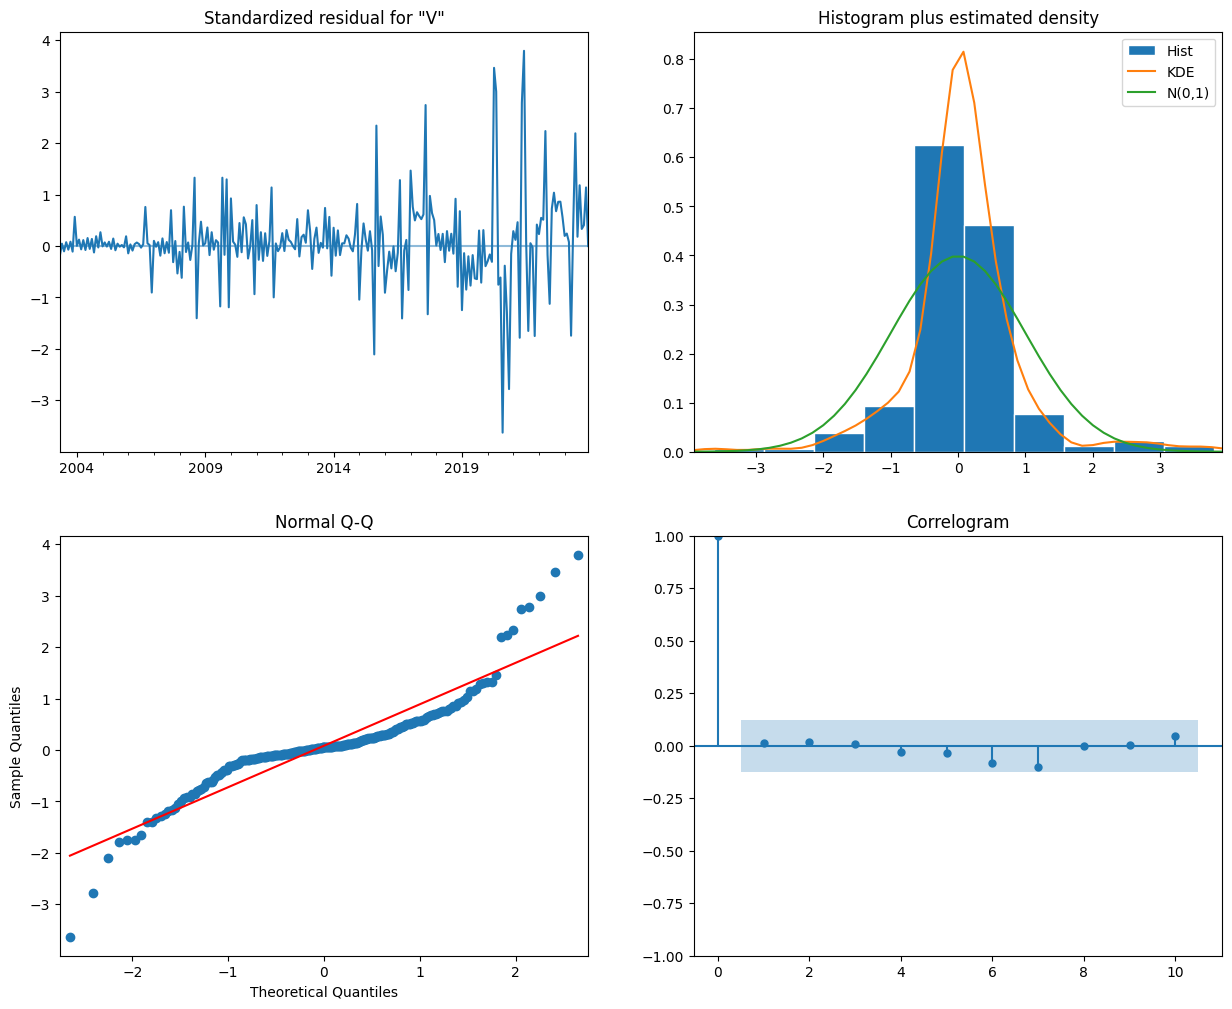

In [84]:
# Adjust the SARIMA model parameters to reduce the number of lags
# Example: Reduce p, q, P, and Q values
adjusted_result_df = result_df[(result_df['p'] <= 3) & (result_df['q'] <= 3) & (result_df['P'] <= 2) & (result_df['Q'] <= 2)]

# Ensure there are enough observations for the selected parameters
if len(adjusted_result_df) > 0:
	# Use the first valid parameter set from the adjusted DataFrame
	best_params = adjusted_result_df.iloc[0]
	p, d, q = int(best_params['p']), int(best_params['d']), int(best_params['q'])
	P, D, Q = int(best_params['P']), int(best_params['D']), int(best_params['Q'])
	s = 12  # Seasonal period remains the same

	# Refit the SARIMA model with adjusted parameters
	adjusted_model = sm.tsa.statespace.SARIMAX(
		df_sarima['Valor'],
		order=(p, d, q),
		seasonal_order=(P, D, Q, s),
		enforce_stationarity=False,
		enforce_invertibility=False
	)
	adjusted_result = adjusted_model.fit()

	# Plot diagnostics for the adjusted model
	adjusted_result.plot_diagnostics(figsize=(15, 12))
	plt.grid(False)
	plt.show()
else:
	print("No valid parameter set found with reduced lags.")

In [85]:
df_sarima['fitted'] = resultado_modelo.fittedvalues

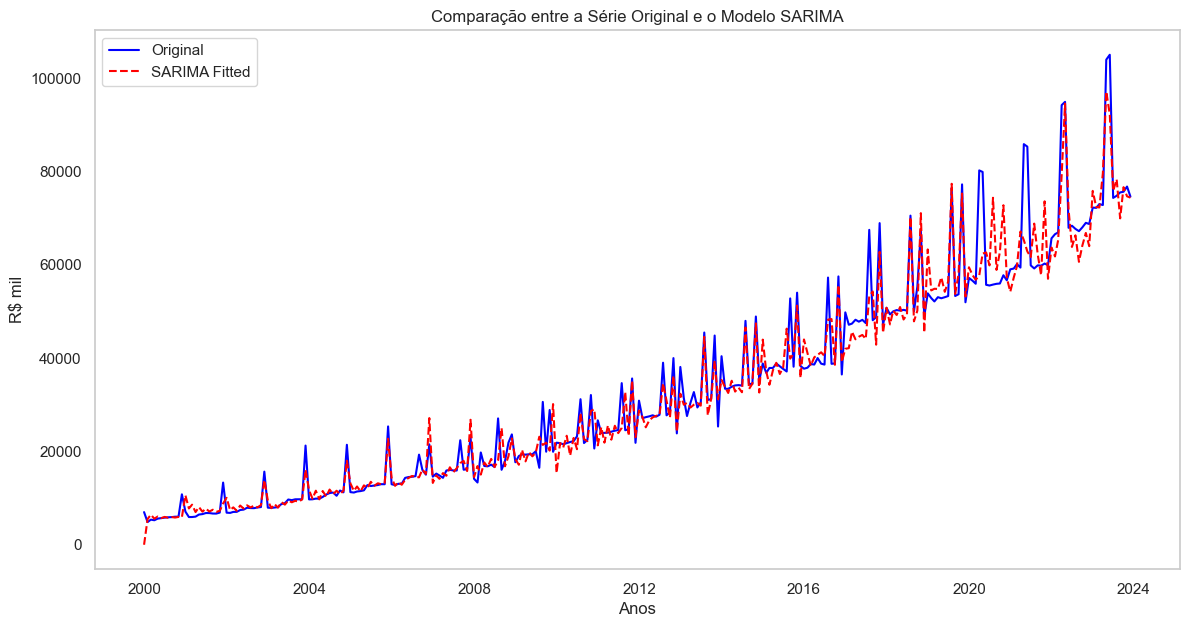

In [86]:
sns.set_theme(style="whitegrid")

# Plotando a série original e os valores ajustados pelo modelo
plt.figure(figsize=(14, 7))
plt.tight_layout()
sns.lineplot(data=df_sarima, x=df_sarima.index, y='Valor', label='Original', color='blue')
sns.lineplot(data=df_sarima, x=df_sarima.index, y='fitted', label='SARIMA Fitted', color='red', linestyle='--')
plt.title('Comparação entre a Série Original e o Modelo SARIMA')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Anos')
plt.ylabel('R$ mil')
plt.grid(False) 
plt.legend()
plt.show()

In [87]:
# Criando a figura
fig = go.Figure()

# Adicionando a série original
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['Valor'],
    mode='lines',
    name='Original',
    line=dict(color='blue')
))

# Adicionando os valores ajustados pelo modelo SARIMA
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['fitted'],
    mode='lines',
    name='SARIMA Fitted',
    line=dict(color='red', dash='dash')
))

# Configurando o layout
fig.update_layout(
    title='Comparação entre a Série Original e o Modelo SARIMA',
    xaxis_title='Anos',
    yaxis_title='R$ mil',
    yaxis=dict(tickformat=',d'),  # Formata os valores inteiros no eixo Y
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico interativo
fig.show()

In [88]:

pio.renderers.default = 'browser'  # Faz com que o gráfico abra no navegador
fig.show()

In [89]:


# Configurando para exibir no VS Code e no navegador
pio.renderers.default = "vscode"  # Para exibição no VS Code
# pio.renderers.default = "browser"  # Se quiser apenas no navegador

# Calculando a diferença entre a série real e o modelo ajustado
df_sarima['erro'] = df_sarima['Valor'] - df_sarima['fitted']

# Criando a figura
fig = go.Figure()

# Adicionando a linha fixa no Y = 0
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=[0] * len(df_sarima),  # Linha fixa no zero
    mode='lines',
    name='Linha Base (Y=0)',
    line=dict(color='black', dash='dash')
))

# Adicionando a série de erros (diferença entre real e ajustado)
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['erro'],
    mode='lines',
    name='Erro (Real - Modelo)',
    line=dict(color='red')
))

# Configurando o layout
fig.update_layout(
    title='Erro entre a Série Real e o Modelo SARIMA',
    xaxis_title='Anos',
    yaxis_title='Erro (R$ mil)',
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico no VS Code
fig.show()

# Exibir gráfico no navegador
pio.renderers.default = "browser"
fig.show()

In [90]:
# Realizando o teste dos erros
teste = teste_erro(df_sarima['Valor'], df_sarima['fitted'])
teste

,Metric,Value
0,MAD,2.773453e+03
1,MAPE,9.164721e-02
2,MSD,2.147032e+07
3,MPE,-4.218160e-01


In [91]:
# Teste para anos antes de 2020
teste_antes = teste_erro(df_sarima.loc[df_sarima.index < '2020-01-01', 'Valor'], df_sarima.loc[df_sarima.index < '2020-01-01', 'fitted'])
teste_antes

,Metric,Value
0,MAD,2.139853e+03
1,MAPE,9.305320e-02
2,MSD,1.111012e+07
3,MPE,-5.960836e-01


In [92]:
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_arch

residuos = resultado_modelo.resid

# Teste de Shapiro-Wilk
shapiro_test = shapiro(residuos)

# Teste de Heterocedasticidade ARCH
arch_test = het_arch(residuos)

# Resultados
test_results = {
    "Shapiro-Wilk": {"Statistic": shapiro_test.statistic, "p-value": shapiro_test.pvalue},
    "ARCH Test": {"LM Statistic": arch_test[0], "p-value": arch_test[1]}
}

test_results


{'Shapiro-Wilk': {'Statistic': np.float64(0.8556818374764061),
  'p-value': np.float64(1.0030615916484366e-15)},
 'ARCH Test': {'LM Statistic': np.float64(54.77072338029318),
  'p-value': np.float64(3.485249114317018e-08)}}

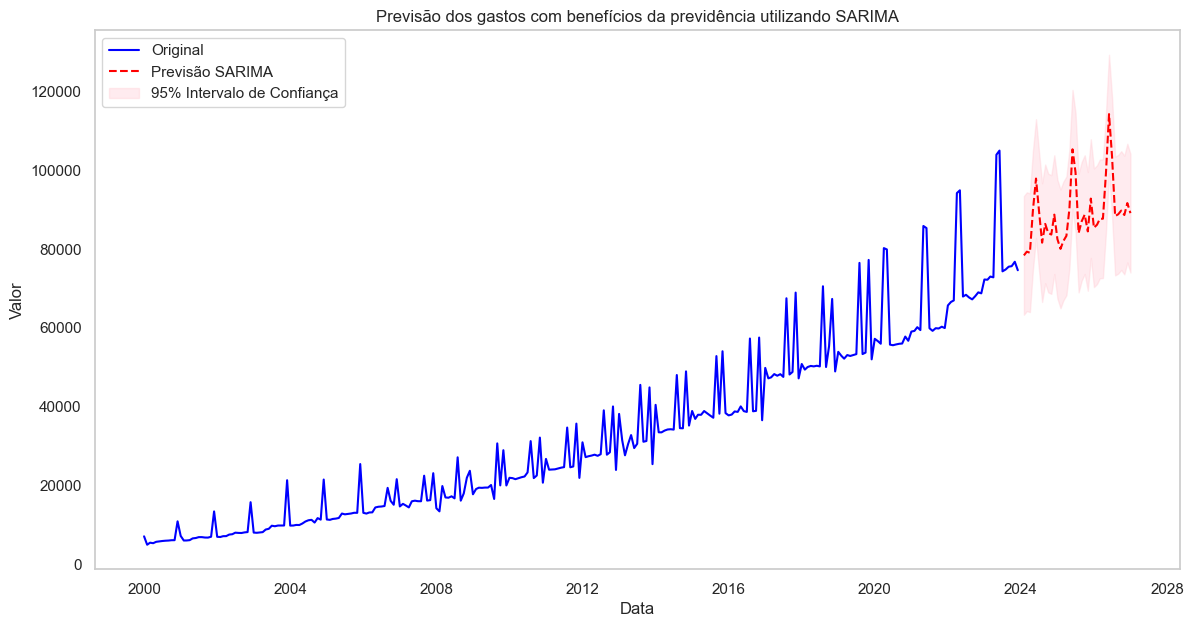

In [93]:
# Criando as previsões
forecast_periods = 36
forecast = resultado_modelo.forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=df_sarima.index[-1], periods=forecast_periods+1, freq='M')[1:]
forecast_values = forecast.values

# Fazendo intervalo de confiança
ci = 1.96 * np.std(forecast_values)
lower_bound = forecast_values - ci
upper_bound = forecast_values + ci

# Fazendo os gráficos
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_sarima, x=df_sarima.index, y='Valor', label='Original', color='blue')
sns.lineplot(x=forecast_index, y=forecast_values, label='Previsão SARIMA', color='red', linestyle='--')
plt.fill_between(forecast_index, lower_bound, upper_bound, color='pink', alpha=0.3, label='95% Intervalo de Confiança')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Previsão dos gastos com benefícios da previdência utilizando SARIMA')
plt.grid(False)
plt.legend()
plt.show()

In [94]:
# Criando a figura interativa
fig = go.Figure()

# Configurar o Plotly para exibir no VS Code primeiro
pio.renderers.default = "vscode"

# Linha da série original
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['Valor'],
    mode='lines',
    name='Original',
    line=dict(color='blue')
))

# Linha da previsão SARIMA
fig.add_trace(go.Scatter(
    x=forecast_index,
    y=forecast_values,
    mode='lines',
    name='Previsão SARIMA',
    line=dict(color='red', dash='dash')
))

# Área do intervalo de confiança
fig.add_trace(go.Scatter(
    x=list(forecast_index) + list(forecast_index[::-1]),
    y=list(upper_bound) + list(lower_bound[::-1]),
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.3)',  # Cor rosa com transparência
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Intervalo de Confiança'
))

# Configurações do layout
fig.update_layout(
    title='Previsão dos gastos com benefícios da previdência utilizando SARIMA',
    xaxis_title='Anos',
    yaxis_title='R$ mil',
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico no VS Code
fig.show()


In [95]:
# Exibir gráfico no navegador
pio.renderers.default = "browser"
fig.show()